### Installs and Imports

In [1]:
!pip install tensorflow --quiet
!pip install transformers --quiet

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import BertTokenizer, TFBertModel, AutoTokenizer, TFAutoModel

from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Mounted at /content/drive


### Global Parameters

In [3]:
FILE_PATH = '/content/drive/MyDrive/DS_266/data/'

TRAIN_DATA_SIZE = 10000
TEST_DATA_SIZE = 5000
MAX_SEQUENCE_LENGTH = 256

HIDDEN_SIZE = 100
DROPOUT = 0.3
LEARNING_RATE = 0.00005

VALIDATION_SPLIT = 0.2
BATCH_SIZE = 16
NUM_EPOCHS = 2

# Replace with your HuggingFace token
with open(f'{FILE_PATH}hf_Token.txt', 'r') as f:
    AUTH_TOKEN = f.read()

### Data Preprocessing

In [4]:
subreddit_list = {
    'conspiracy': 0,
    'divorce': 0,
    'fitness': 0,
    'guns': 0,
    'jokes': 0,
    'legaladvice': 0,
    'meditation': 0,
    'parenting': 0,
    'personalfinance': 0,
    'relationships': 0,
    'teaching': 0,
    'mentalhealth': 1,
    'EDAnonymous': 1,
    'addiction': 1,
    'alcoholism': 1,
    'adhd': 1,
    'anxiety': 1,
    'autism': 1,
    'bipolarreddit': 1,
    'bpd': 1,
    'depression': 1,
    'healthanxiety': 1,
    'lonely': 1,
    'ptsd': 1,
    'schizophrenia': 1,
    'socialanxiety': 1,
    'suicidewatch': 1
}

# Define a function to read and process a single CSV
def read_and_label_csv(subreddit, time_period):
    df = pd.read_csv(f'{FILE_PATH}{subreddit}_{time_period}_features_tfidf_256.csv')
    df = df[['subreddit', 'author', 'date', 'post']]
    df = df[df['subreddit'].isin(subreddit_list.keys())]
    df['suicide_risk'] = df['subreddit'].apply(lambda x: 1 if x == 'suicidewatch' else 0)
    df['mental_health'] = df['subreddit'].apply(lambda x: 1 if x in [k for k, v in subreddit_list.items() if v == 1] else 0)
    return df

# Identify unique authors that posted in r/suicidewatch
suicidal_authors = set(pd.concat([read_and_label_csv('suicidewatch', time_period) for time_period in ['2018', '2019', 'pre', 'post']])['author'])

# Generate training and test data with labels
train_data = pd.concat([read_and_label_csv(subreddit, 'pre') for subreddit in subreddit_list])
test_data = pd.concat([read_and_label_csv(subreddit, 'post') for subreddit in subreddit_list])

# Take a subset of the data ensuring balance between positive and negative labels
train_data_positive = train_data[train_data['suicide_risk'] == 1].sample(n=TRAIN_DATA_SIZE//2, random_state=42)
train_data_negative = train_data[train_data['suicide_risk'] == 0].sample(n=TRAIN_DATA_SIZE//2, random_state=42)
train_data = pd.concat([train_data_positive, train_data_negative]).sample(frac=1, random_state=42)
train_data['date'] = pd.to_datetime(train_data['date']).dt.strftime('%Y-%m')

test_data_positive = test_data[test_data['suicide_risk'] == 1].sample(n=TEST_DATA_SIZE//2, random_state=42)
test_data_negative = test_data[test_data['suicide_risk'] == 0].sample(n=TEST_DATA_SIZE//2, random_state=42)
test_data = pd.concat([test_data_positive, test_data_negative]).sample(frac=1, random_state=42)
test_data['date'] = pd.to_datetime(test_data['date']).dt.strftime('%Y-%m')
test_data['suicidal_author'] = test_data['author'].apply(lambda x: 1 if x in suicidal_authors else 0)

# Collect examples and labels for tokenization and modeling
train_examples = train_data['post'].to_list()
train_labels = train_data['suicide_risk'].to_numpy()
test_examples = test_data['post'].to_list()
test_labels = test_data['suicide_risk'].to_numpy()

### Helper Functions

In [5]:
def tokenize_inputs(tokenizer, examples):
    """
    Tokenize the input text for the each of the BERT model variations to use.
    """
    tokenized_inputs = tokenizer(
        examples,
        max_length=MAX_SEQUENCE_LENGTH,
        truncation=True,
        padding='max_length',
        return_tensors='tf'
    )
    return [
        tokenized_inputs.input_ids,
        tokenized_inputs.token_type_ids,
        tokenized_inputs.attention_mask
    ]

def create_cls_model(
        bert_model,
        bert_trainable,
        max_sequence_length=MAX_SEQUENCE_LENGTH,
        hidden_size=HIDDEN_SIZE,
        dropout=DROPOUT,
        learning_rate=LEARNING_RATE
    ):
    """
    Build a simple classification model using a BERT encoder model. Use the CLS Token output for classification purposes.
    """

    bert_model.trainable = bert_trainable

    input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int32, name='input_ids')
    token_type_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int32, name='token_type_ids')
    attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int32, name='attention_mask')
    bert_inputs = {
        'input_ids': input_ids,
        'token_type_ids': token_type_ids,
        'attention_mask': attention_mask
    }
    bert_output = bert_model(bert_inputs)

    cls_token = bert_output[0][:, 0, :]
    hidden_layer = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(cls_token)
    dropout_layer = tf.keras.layers.Dropout(dropout, name='dropout_layer')(hidden_layer)
    classification_layer = tf.keras.layers.Dense(1, activation='sigmoid', name='classification_layer')(dropout_layer)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification_layer])
    classification_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return classification_model

### Tokenizers

In [6]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
bert_train_inputs = tokenize_inputs(bert_tokenizer, train_examples)
bert_test_inputs = tokenize_inputs(bert_tokenizer, test_examples)

mentalbert_tokenizer = AutoTokenizer.from_pretrained('mental/mental-bert-base-uncased', use_auth_token=AUTH_TOKEN)
mentalbert_train_inputs = tokenize_inputs(mentalbert_tokenizer, train_examples)
mentalbert_test_inputs = tokenize_inputs(mentalbert_tokenizer, test_examples)

disorbert_tokenizer = AutoTokenizer.from_pretrained('citiusLTL/DisorBERT')
disorbert_train_inputs = tokenize_inputs(disorbert_tokenizer, train_examples)
disorbert_test_inputs = tokenize_inputs(disorbert_tokenizer, test_examples)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/tokenization_auto.py:809: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/321 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

### BERT Baseline Model

In [7]:
bert_baseline = create_cls_model(
    TFBertModel.from_pretrained('bert-base-cased'),
    bert_trainable=False,
    max_sequence_length=MAX_SEQUENCE_LENGTH,
    hidden_size=HIDDEN_SIZE,
    dropout=DROPOUT,
    learning_rate=LEARNING_RATE
)
bert_baseline.fit(
    bert_train_inputs,
    train_labels,
    validation_split=VALIDATION_SPLIT,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS
)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/2
500/500 [==============================] - 212s 402ms/step - loss: 0.6298 - accuracy: 0.6491 - val_loss: 0.5227 - val_accuracy: 0.7685
Epoch 2/2
500/500 [==============================] - 201s 402ms/step - loss: 0.5292 - accuracy: 0.7499 - val_loss: 0.4769 - val_accuracy: 0.7880


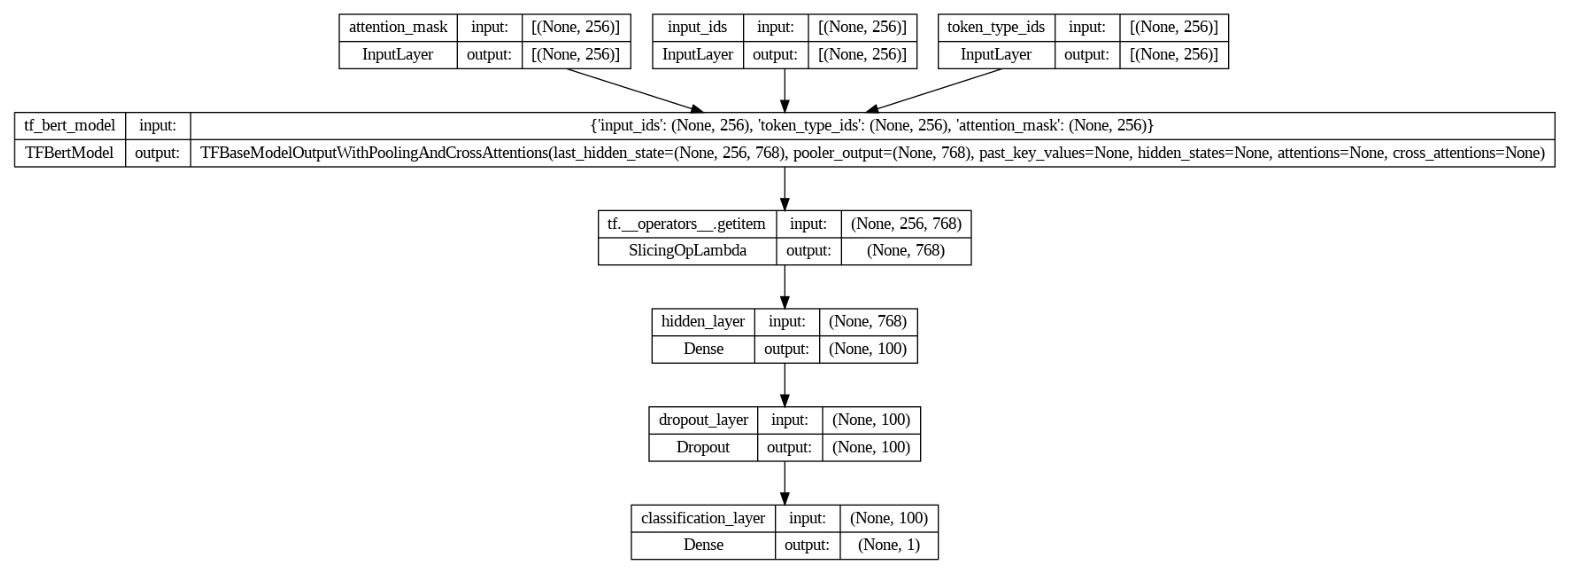

In [17]:
tf.keras.utils.plot_model(bert_baseline, show_shapes=True, to_file='bert_baseline_diagram.png')

plt.figure(figsize=(20, 10))
plt.imshow(plt.imread('bert_baseline_diagram.png'))
plt.axis('off')
plt.show()

### MentalBERT Baseline Model

In [8]:
mentalbert_baseline = create_cls_model(
    TFAutoModel.from_pretrained('mental/mental-bert-base-uncased', use_auth_token=AUTH_TOKEN, from_pt=True),
    bert_trainable=False,
    max_sequence_length=MAX_SEQUENCE_LENGTH,
    hidden_size=HIDDEN_SIZE,
    dropout=DROPOUT,
    learning_rate=LEARNING_RATE
)
mentalbert_baseline.fit(
    mentalbert_train_inputs,
    train_labels,
    validation_split=VALIDATION_SPLIT,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS
)

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/auto_factory.py:471: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


config.json:   0%|          | 0.00/639 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'bert.embeddings.position_ids', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertModel were not initialized from the PyTorch model and are newly initialized: ['bert.pooler.dense.weight', 'bert.p

Epoch 1/2
500/500 [==============================] - 211s 408ms/step - loss: 0.4638 - accuracy: 0.7872 - val_loss: 0.3480 - val_accuracy: 0.8525
Epoch 2/2
500/500 [==============================] - 204s 408ms/step - loss: 0.3561 - accuracy: 0.8475 - val_loss: 0.3172 - val_accuracy: 0.8655


### DisorBERT Baseline Model

In [9]:
disorbert_baseline = create_cls_model(
    TFAutoModel.from_pretrained('citiusLTL/DisorBERT', from_pt=True),
    bert_trainable=False,
    max_sequence_length=MAX_SEQUENCE_LENGTH,
    hidden_size=HIDDEN_SIZE,
    dropout=DROPOUT,
    learning_rate=LEARNING_RATE
)
disorbert_baseline.fit(
    disorbert_train_inputs,
    train_labels,
    validation_split=VALIDATION_SPLIT,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS
)

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'bert.embeddings.position_ids', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertModel were not initialized from the PyTorch model and are newly initialized: ['bert.pooler.dense.weight', 'bert.p

Epoch 1/2
500/500 [==============================] - 216s 415ms/step - loss: 0.5856 - accuracy: 0.6971 - val_loss: 0.4771 - val_accuracy: 0.7915
Epoch 2/2
500/500 [==============================] - 205s 409ms/step - loss: 0.4775 - accuracy: 0.7875 - val_loss: 0.4293 - val_accuracy: 0.8085


### BERT Fine-Tuned Model

In [10]:
bert_finetuned = create_cls_model(
    TFBertModel.from_pretrained('bert-base-cased'),
    bert_trainable=True,
    max_sequence_length=MAX_SEQUENCE_LENGTH,
    hidden_size=HIDDEN_SIZE,
    dropout=DROPOUT,
    learning_rate=LEARNING_RATE
)
bert_finetuned.fit(
    bert_train_inputs,
    train_labels,
    validation_split=VALIDATION_SPLIT,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/2


500/500 [==============================] - 512s 958ms/step - loss: 0.3185 - accuracy: 0.8731 - val_loss: 0.2420 - val_accuracy: 0.9025
Epoch 2/2
500/500 [==============================] - 476s 953ms/step - loss: 0.1826 - accuracy: 0.9361 - val_loss: 0.2503 - val_accuracy: 0.9105


### MentalBERT Fine-Tuned Model

In [11]:
mentalbert_finetuned = create_cls_model(
    TFAutoModel.from_pretrained('mental/mental-bert-base-uncased', use_auth_token=AUTH_TOKEN, from_pt=True),
    bert_trainable=True,
    max_sequence_length=MAX_SEQUENCE_LENGTH,
    hidden_size=HIDDEN_SIZE,
    dropout=DROPOUT,
    learning_rate=LEARNING_RATE
)
mentalbert_finetuned.fit(
    mentalbert_train_inputs,
    train_labels,
    validation_split=VALIDATION_SPLIT,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'bert.embeddings.position_ids', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertModel were not initialized from the PyTorch model and are newly initialized: ['bert.pooler.dense.weight', 'bert.p

Epoch 1/2


500/500 [==============================] - 508s 958ms/step - loss: 0.2904 - accuracy: 0.8846 - val_loss: 0.2274 - val_accuracy: 0.9130
Epoch 2/2
500/500 [==============================] - 476s 953ms/step - loss: 0.1506 - accuracy: 0.9474 - val_loss: 0.3176 - val_accuracy: 0.9040


### DisorBERT Fine-Tuned Model

In [12]:
disorbert_finetuned = create_cls_model(
    TFAutoModel.from_pretrained('citiusLTL/DisorBERT', from_pt=True),
    bert_trainable=True,
    max_sequence_length=MAX_SEQUENCE_LENGTH,
    hidden_size=HIDDEN_SIZE,
    dropout=DROPOUT,
    learning_rate=LEARNING_RATE
)
disorbert_finetuned.fit(
    disorbert_train_inputs,
    train_labels,
    validation_split=VALIDATION_SPLIT,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'bert.embeddings.position_ids', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertModel were not initialized from the PyTorch model and are newly initialized: ['bert.pooler.dense.weight', 'bert.p

Epoch 1/2


500/500 [==============================] - 505s 951ms/step - loss: 0.3262 - accuracy: 0.8665 - val_loss: 0.2534 - val_accuracy: 0.9045
Epoch 2/2
500/500 [==============================] - 476s 953ms/step - loss: 0.1905 - accuracy: 0.9306 - val_loss: 0.2613 - val_accuracy: 0.9015


### Predictions and Evaluations

In [13]:
test_predictions = {
    'bert_baseline': np.rint(bert_baseline.predict(bert_test_inputs)).astype(int),
    'mentalbert_baseline': np.rint(mentalbert_baseline.predict(mentalbert_test_inputs)).astype(int),
    'disorbert_baseline': np.rint(disorbert_baseline.predict(disorbert_test_inputs)).astype(int),
    'bert_finetuned': np.rint(bert_finetuned.predict(bert_test_inputs)).astype(int),
    'mentalbert_finetuned': np.rint(mentalbert_finetuned.predict(mentalbert_test_inputs)).astype(int),
    'disorbert_finetuned': np.rint(disorbert_finetuned.predict(disorbert_test_inputs)).astype(int)
}

evaluation_df = test_data.reset_index().drop(columns='index')

for col in test_predictions.keys():
    evaluation_df[col] = test_predictions[col].flatten()

def compute_metrics(model, predictions, test_labels):
    return {
        'model': model,
        'accuracy': accuracy_score(test_labels, predictions),
        'precision': precision_score(test_labels, predictions),
        'recall': recall_score(test_labels, predictions),
        'f1_score': f1_score(test_labels, predictions)
    }

metrics = [compute_metrics(model, test_prediction, test_labels) for model, test_prediction in test_predictions.items()]
pd.DataFrame(metrics)

157/157 [==============================] - 98s 601ms/step


,model,accuracy,precision,recall,f1_score
0,bert_baseline,0.7836,0.773323,0.8024,0.787593
1,mentalbert_baseline,0.8618,0.841966,0.8908,0.865695
2,disorbert_baseline,0.8144,0.799315,0.8396,0.818962
3,bert_finetuned,0.9004,0.895965,0.9060,0.900955
4,mentalbert_finetuned,0.8972,0.846960,0.9696,0.904140
5,disorbert_finetuned,0.9084,0.873446,0.9552,0.912495


<ipython-input-14-b30467fe165f>:42: UserWarning: The figure layout has changed to tight
  plt.tight_layout()  # Adjust layout to prevent labels from overlapping


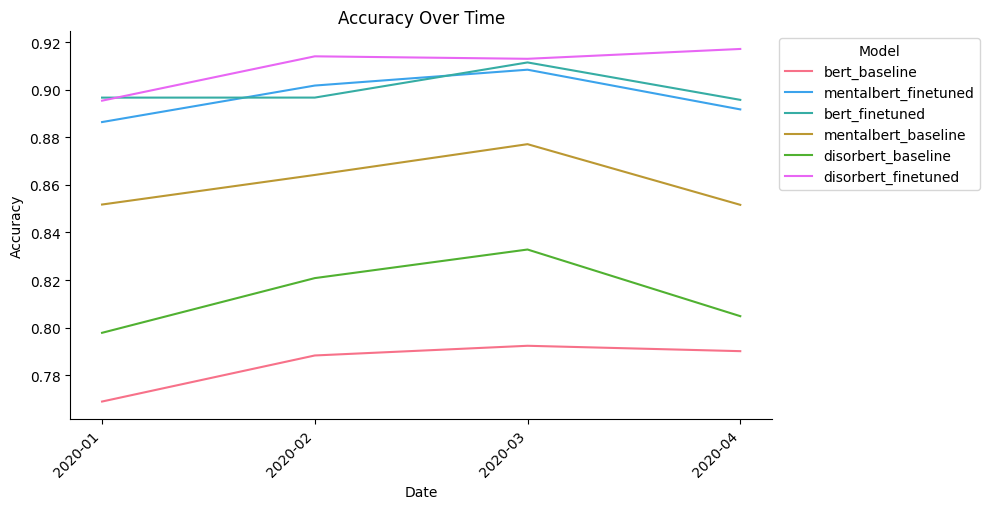

<ipython-input-14-b30467fe165f>:42: UserWarning: The figure layout has changed to tight
  plt.tight_layout()  # Adjust layout to prevent labels from overlapping


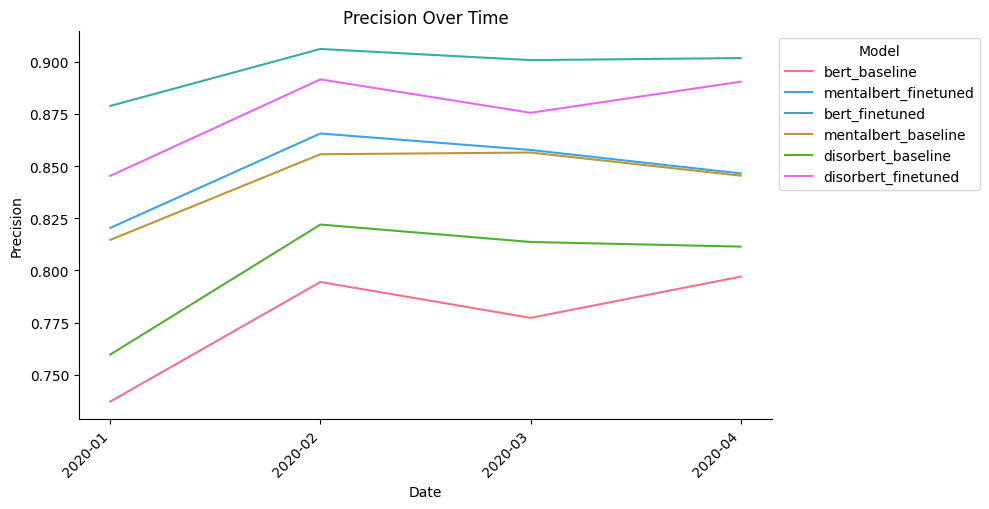

<ipython-input-14-b30467fe165f>:42: UserWarning: The figure layout has changed to tight
  plt.tight_layout()  # Adjust layout to prevent labels from overlapping


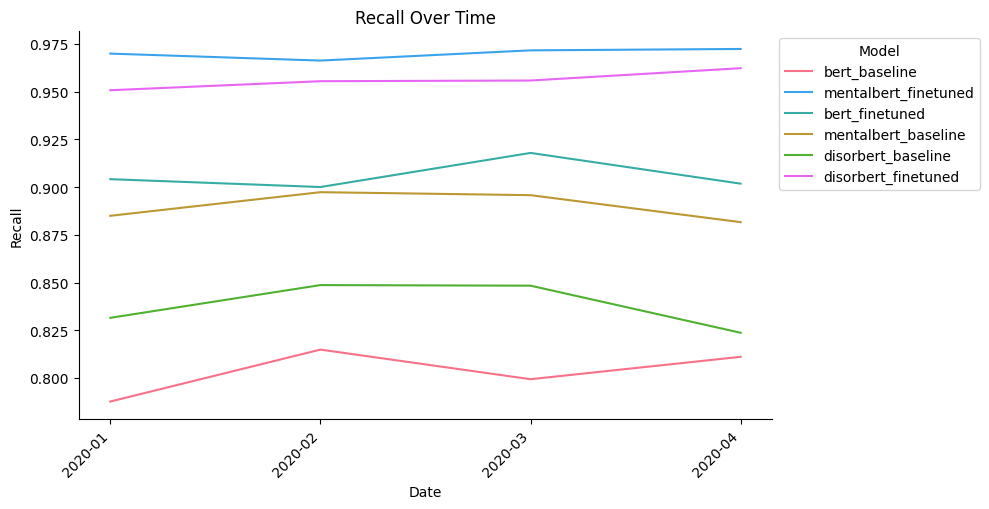

<ipython-input-14-b30467fe165f>:42: UserWarning: The figure layout has changed to tight
  plt.tight_layout()  # Adjust layout to prevent labels from overlapping


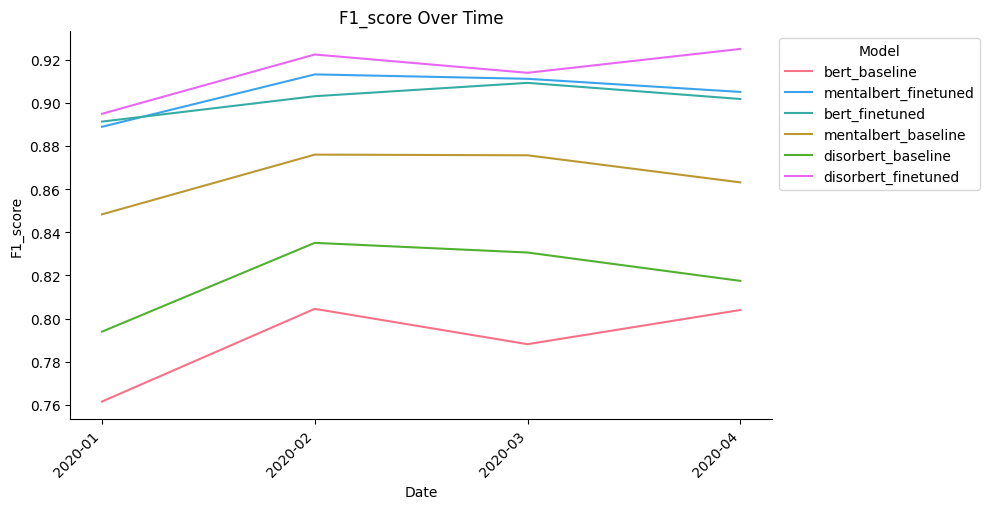

In [14]:
# Do the metrics get worse over time throughout the onset of COVID-19?

results = []
for model_name in test_predictions.keys():
    for date, group in evaluation_df.groupby('date'):
        y_true = group['suicide_risk'].values
        y_pred = group[model_name].values

        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, zero_division=0) # Handle potential zero division
        recall = recall_score(y_true, y_pred, zero_division=0) # Handle potential zero division
        f1 = f1_score(y_true, y_pred, zero_division=0) # Handle potential zero division

        results.append({
            'model': model_name,
            'date': date,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        })

results_df = pd.DataFrame(results)

def plot_metric_over_time(metric, results_df):
    """Plots a specified metric over time for all models."""

    fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
    df_sorted = results_df.sort_values('date', ascending=True)

    palette = sns.color_palette("husl", n_colors=len(results_df['model'].unique()))
    model_palette = dict(zip(results_df['model'].unique(), palette))

    sns.lineplot(data=df_sorted, x='date', y=metric, hue='model', palette=model_palette, ax=ax)

    sns.despine(fig=fig, ax=ax)
    plt.xlabel('Date')
    plt.ylabel(metric.capitalize())
    plt.title(f'{metric.capitalize()} Over Time')
    plt.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent labels from overlapping
    plt.show()

# Plot each metric
metrics = ['accuracy', 'precision', 'recall', 'f1_score']
for metric in metrics:
    plot_metric_over_time(metric, results_df)

<ipython-input-32-74f47130ff20>:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  false_positive_rates = grouped_df.apply(lambda x: sum((x[model_name] == 1) & (x['suicide_risk'] == 0)) / len(x))
<ipython-input-32-74f47130ff20>:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  false_positive_rates = grouped_df.apply(lambda x: sum((x[model_name] == 1) & (x['suicide_risk'] == 0)) / len(x))
<ipython-input-32-74

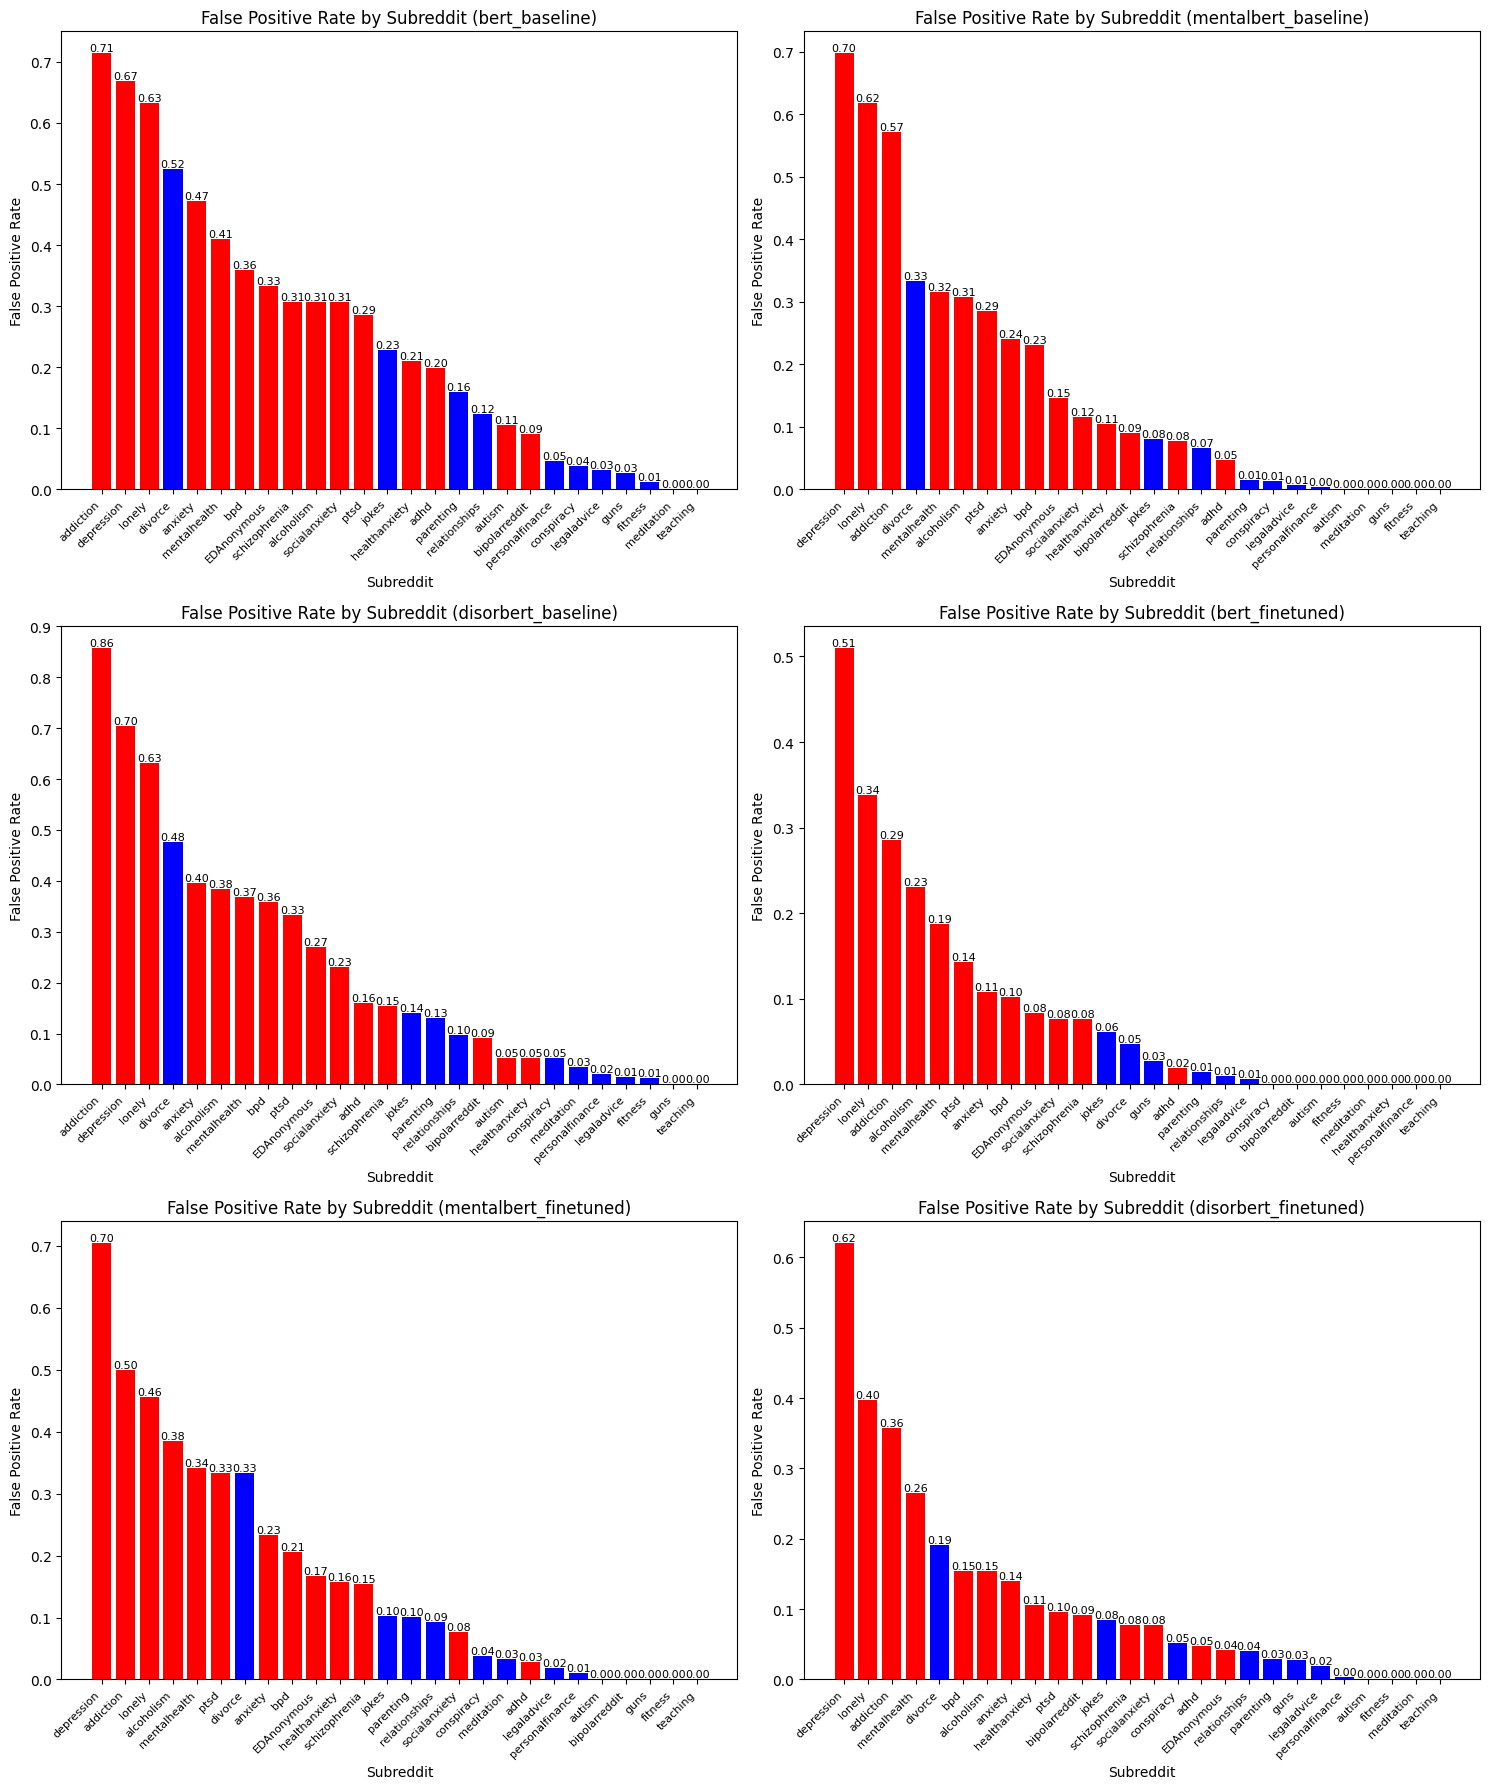

In [32]:
# Do false positives become more frequent for mental health vs non-mental health subreddits?

def plot_false_positive_rates(evaluation_df, models):
    """Plots the false positive rates for multiple models in a grid."""

    num_models = len(models)
    fig, axes = plt.subplots(3, 2, figsize=(15, 18))  # Create a 3x2 grid of subplots
    axes = axes.flatten() # Convert 2D array of axes to 1D

    for i, model_name in enumerate(models):
        if i < num_models:
          ax = axes[i]
          grouped_df = evaluation_df[evaluation_df['subreddit'] != 'suicidewatch'].groupby('subreddit')
          false_positive_rates = grouped_df.apply(lambda x: sum((x[model_name] == 1) & (x['suicide_risk'] == 0)) / len(x))
          false_positive_rates = false_positive_rates.sort_values(ascending=False)

          colors = ['red' if sub in [k for k, v in subreddit_list.items() if v == 1] else 'blue' for sub in false_positive_rates.index]

          ax.bar(false_positive_rates.index, false_positive_rates.values, color=colors)
          ax.set_xlabel("Subreddit")
          ax.set_ylabel("False Positive Rate")
          ax.bar_label(ax.containers[0], label_type='edge', fmt='%.2f', fontsize=8)
          ax.set_title(f"False Positive Rate by Subreddit ({model_name})")
          ax.tick_params(axis='x', rotation=45, labelsize=8) # Adjust tick label size and rotation
          plt.setp(ax.get_xticklabels(), ha="right") # Align rotated labels
          plt.tight_layout()


    # Turn off any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout() # Adjust layout to prevent overlapping
    plt.show()

models_to_plot = list(test_predictions.keys())
plot_false_positive_rates(evaluation_df, models_to_plot)

In [16]:
# Do false positives become more frequent for authors who also posted in r/suicidewatch?

filtered_df = evaluation_df[evaluation_df['suicide_risk'] == 0]
results = []

for model in test_predictions.keys():
    fp_suicidal_author = len(filtered_df[(filtered_df['suicidal_author'] == 1) & (filtered_df[model] == 1)]) / len(filtered_df[filtered_df['suicidal_author'] == 1]) if len(filtered_df[filtered_df['suicidal_author'] == 1]) > 0 else 0
    fp_non_suicidal_author = len(filtered_df[(filtered_df['suicidal_author'] == 0) & (filtered_df[model] == 1)]) / len(filtered_df[filtered_df['suicidal_author'] == 0]) if len(filtered_df[filtered_df['suicidal_author'] == 0]) > 0 else 0

    results.append({
        'model': model,
        'false_positive_suicidal_author': fp_suicidal_author,
        'false_positive_non_suicidal_author': fp_non_suicidal_author
    })

pd.DataFrame(results)

,model,false_positive_suicidal_author,false_positive_non_suicidal_author
0,bert_baseline,0.538462,0.223744
1,mentalbert_baseline,0.516484,0.154006
2,disorbert_baseline,0.549451,0.198007
3,bert_finetuned,0.384615,0.094645
4,mentalbert_finetuned,0.461538,0.164384
5,disorbert_finetuned,0.406593,0.128269
